In [2]:
import rasterio as rio
import rioxarray as riox
from matplotlib import pyplot
from src.constants import INTERMEDIATE_RESULTS
from src.data.pipelines.extract_gedi_data import SIERRAS_GEDI_ID_COLUMNS, SEKI_GEDI_ID_COLUMNS
from src.data.processing import disturbance_overlays as do
from src.data.adapters import disturbance_agents as da
from pathlib import Path
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from src import constants
from src.data.utils import gedi_utils
from src.data.processing import overlay
from fastai.tabular.all import load_pickle, save_pickle
from src.data.pipelines import aggregate_analysis as aa

sns.set_theme(style="white", palette="Set2")

import importlib
#importlib.reload(raster)
importlib.reload(do)
importlib.reload(da)

2024-01-23 18:55:32,064 DEBUG: Logger /home/jk871/fire-regen/src/data/utils/raster.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]
2024-01-23 18:55:32,261 DEBUG: Logger /home/jk871/fire-regen/src/data/utils/raster.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]
2024-01-23 18:55:32,262 DEBUG: Logger /home/jk871/fire-regen/src/data/processing/disturbance_overlays.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]
2024-01-23 18:55:32,263 DEBUG: Logger /home/jk871/fire-regen/src/data/adapters/disturbance_agents.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]


<module 'src.data.adapters.disturbance_agents' from '/home/jk871/fire-regen/src/data/adapters/disturbance_agents.py'>

From the dataset website:

"Raster data indicating the timing (annual), location (30 m resolution) and type of disturbance occurring in California in the years 1985 - 2021. Estimates are derived by applying a change detection algorithm to time series of Landsat data and using machine learning, calibrated against existing geospatial datasets, to classify detected breaks. Legend: 1 is fire, 2 is timber harvest, 3 is drought-induced forest die-off, 4 is unattributed greening, and 5 is unattributed browning."

In [3]:
def get_output_path(file_name: str):
    return f"{overlay.OVERLAYS_PATH}/{file_name}"

In [4]:
df = load_pickle(f"{aa.PIPELINES_PATH}/severity_aggregated_info.pkl")

In [5]:
burned = df[df.YSF > 0]
unburned = df[df.YSF < 0]

In [6]:
g = load_pickle(get_output_path("disturbances_overlay.pkl"))

### Disturbance in unburned areas

In [7]:
unburned = unburned.join(g, how="left")

In [8]:

unburned[ (unburned.da_year < unburned.absolute_time.dt.year)]

In [12]:
fire_da = match[match.da_min == 1]
timber_da = match[match.da_min == 2]
drought_da = match[match.da_min == 3]
brown_da = match[match.da_min == 5]
len(fire_da), len(timber_da), len(drought_da), len(brown_da)

(35364, 476883, 16923, 416772)

Interesting, it seems that a lot of the unburned area experienced timber disturbances. I wonder if it's geographically centered.

<AxesSubplot: xlabel='da_min', ylabel='Count'>

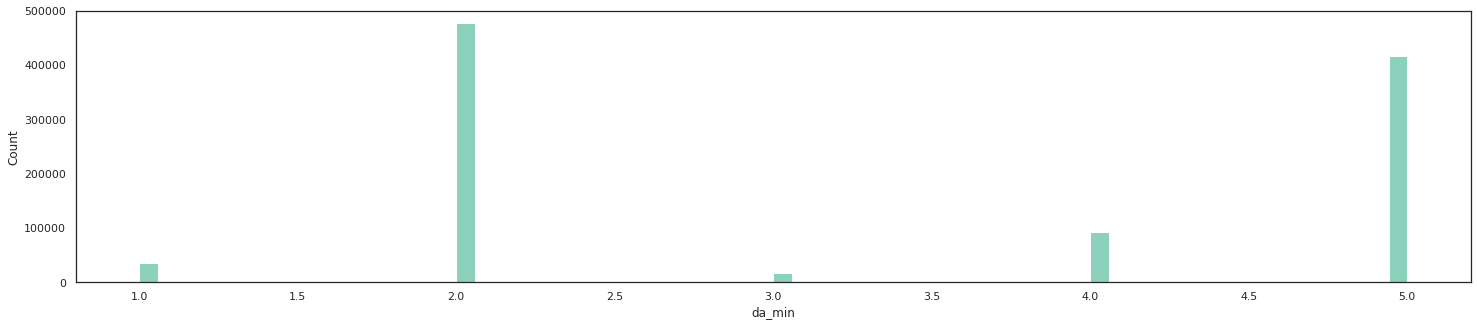

In [11]:
# Let's look at fire disturbances
fig, ax = plt.subplots(1, 1, figsize=(25, 5))
sns.histplot(match, x="da_min")

<AxesSubplot: xlabel='da_year', ylabel='Count'>

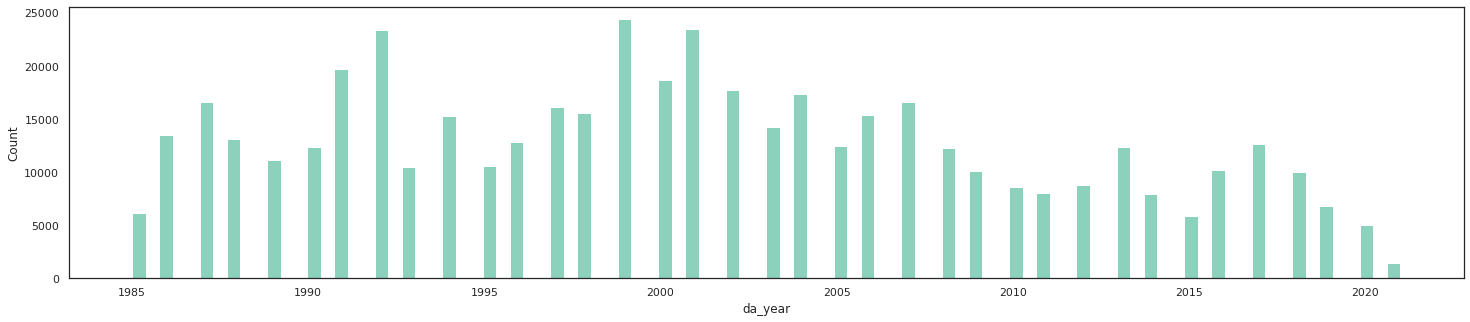

In [13]:
# Let's look at fire disturbances
fig, ax = plt.subplots(1, 1, figsize=(25, 5))
sns.histplot(timber_da, x="da_year")

In [18]:
timber_da["years_from_da"] = timber_da.absolute_time.dt.year - timber_da.da_year

<AxesSubplot: xlabel='years_from_da', ylabel='agbd'>

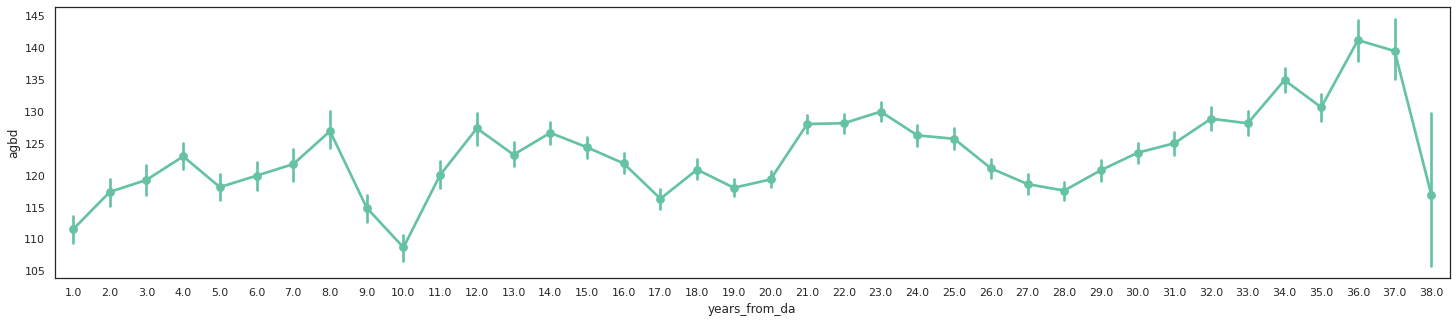

In [20]:
# Let's look at fire disturbances
fig, ax = plt.subplots(1, 1, figsize=(25, 5))
sns.pointplot(timber_da, x="years_from_da", y="agbd")

In [26]:
print(unburned[~unburned.index.isin(match.index)].agbd.mean())
print(unburned[~unburned.index.isin(match.index)].agbd.std())

144.26909629325712
128.7930353624231


In [29]:
print(timber_da[timber_da.years_from_da > 30].agbd.mean())
print(timber_da[timber_da.years_from_da > 30].agbd.std())

130.59354501132168
107.38546031366532


In [30]:
print(brown_da[brown_da.da_std == 0].agbd.mean())
print(brown_da[brown_da.da_std == 0].agbd.std())

59.809281302259556
76.90153003499952


In [52]:
print(brown_da[brown_da.da_std == 0].agbd.mean())
print(brown_da[brown_da.da_std == 0].agbd.std())

41.598632469715234
59.112007238439965


In [55]:
print(brown_da[brown_da.da_mean > 40000].agbd.mean())
print(brown_da[brown_da.da_mean > 40000].agbd.std())

70.98347815954675
86.68570314131178


<AxesSubplot: xlabel='da_mean', ylabel='Count'>

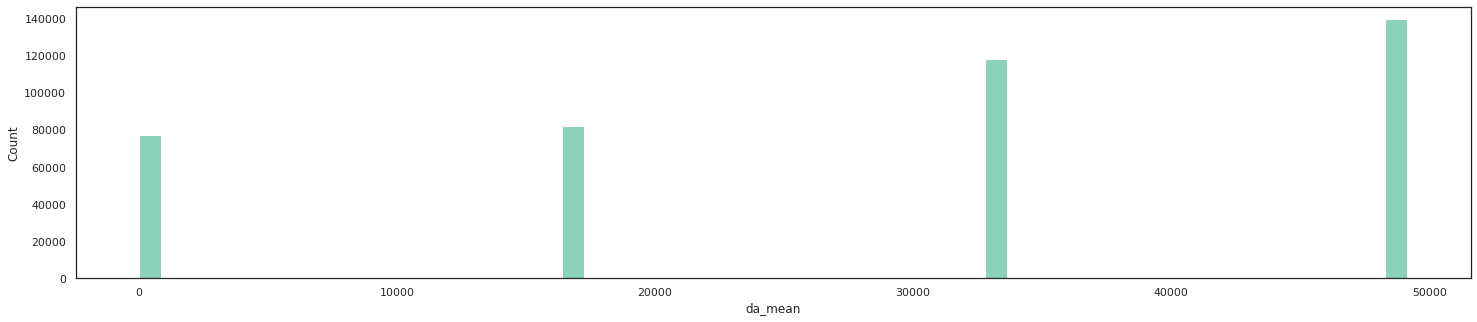

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(25, 5))
sns.histplot(brown_da, x="da_mean")

(0.0, 50.0)

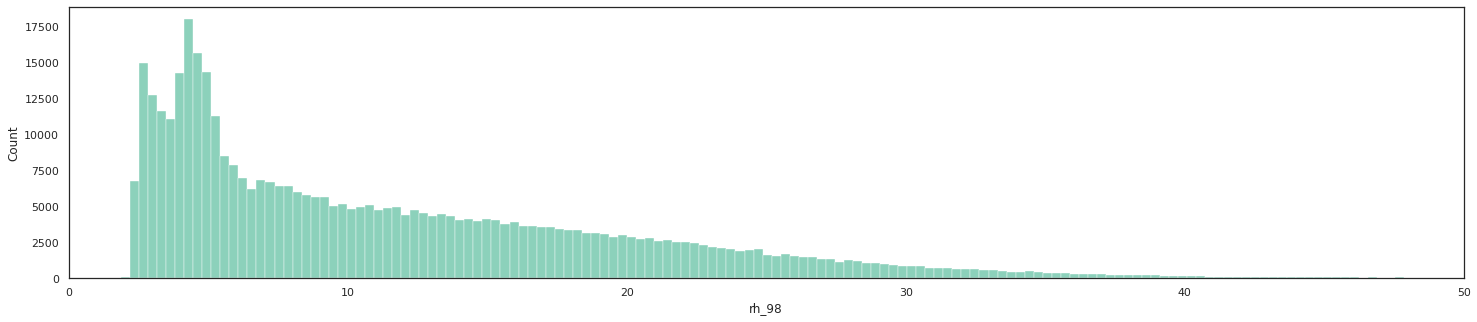

In [70]:
fig, ax = plt.subplots(1, 1, figsize=(25, 5))
sns.histplot(brown_da, x="rh_98")
ax.set_xlim((0, 50))

(0.0, 300.0)

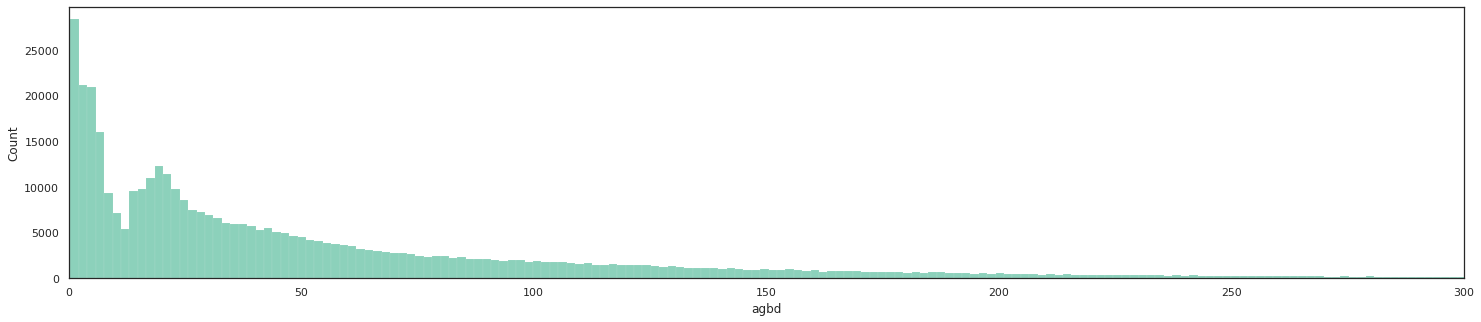

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(25, 5))
sns.histplot(brown_da, x="agbd")
ax.set_xlim((0, 300))

(0.0, 300.0)

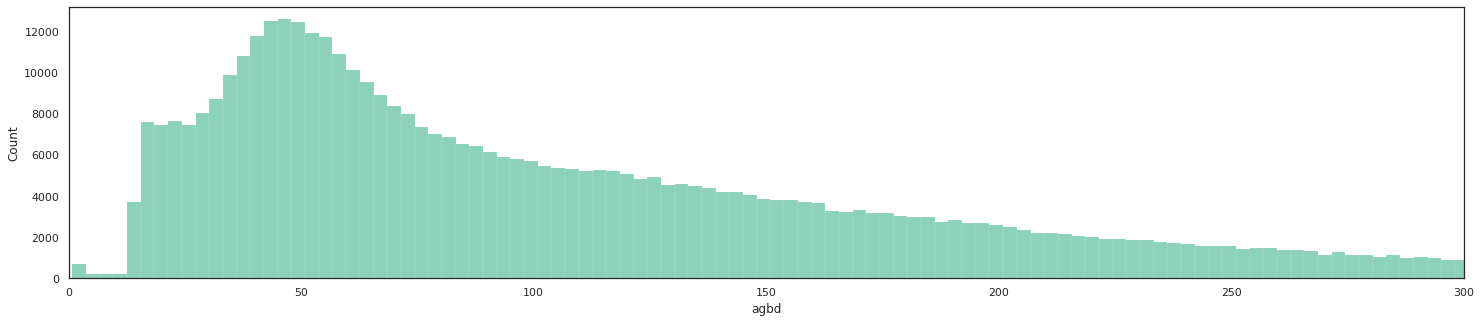

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(25, 5))
sns.histplot(timber_da, x="agbd")
ax.set_xlim((0, 300))

(0.0, 50.0)

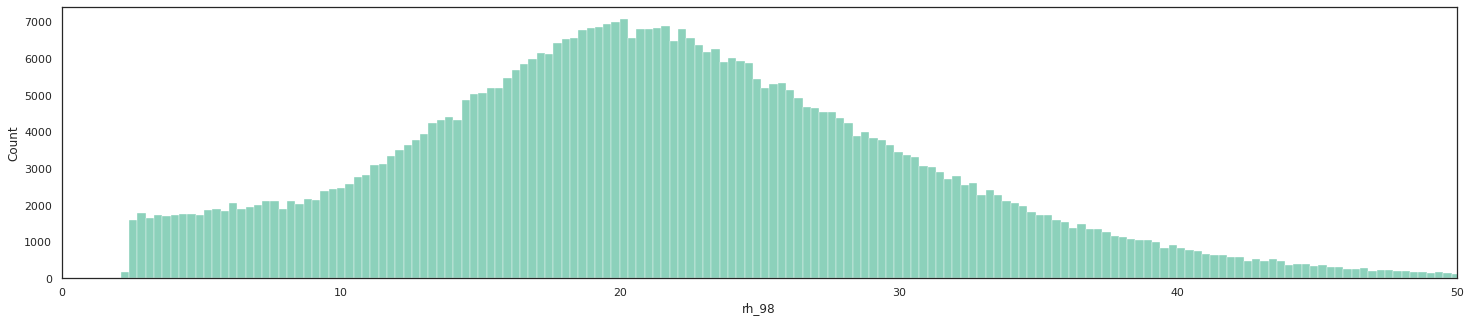

In [71]:
fig, ax = plt.subplots(1, 1, figsize=(25, 5))
sns.histplot(timber_da, x="rh_98")
ax.set_xlim((0, 50))

(0.0, 300.0)

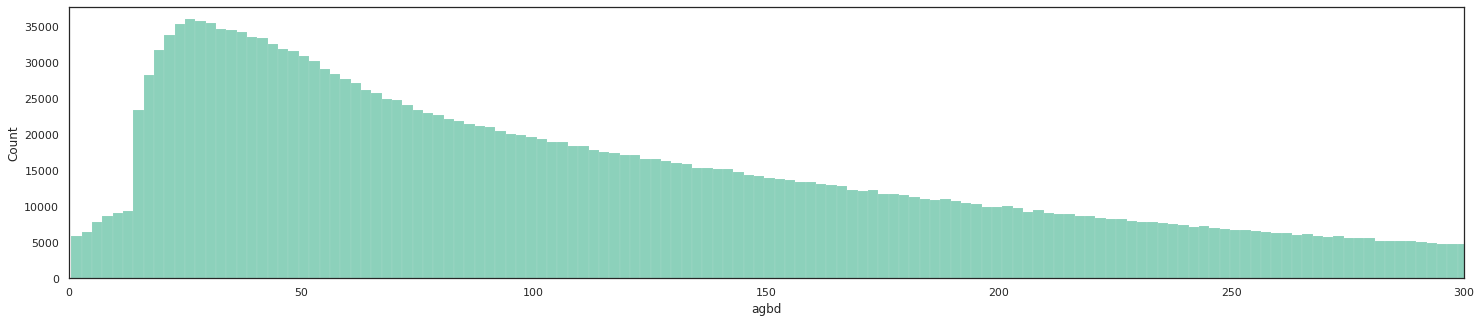

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(25, 5))
sns.histplot(unburned[~unburned.index.isin(match.index)], x="agbd")
ax.set_xlim((0, 300))

(0.0, 50.0)

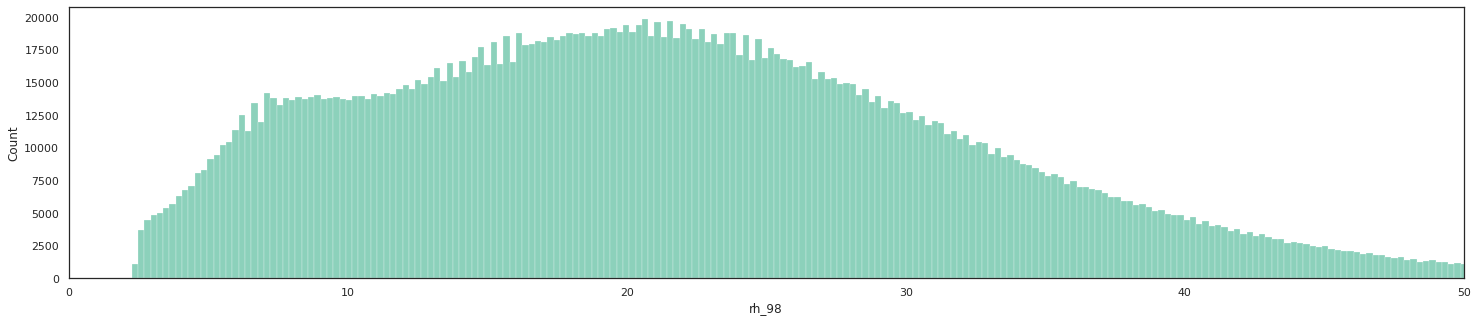

In [72]:
fig, ax = plt.subplots(1, 1, figsize=(25, 5))
sns.histplot(unburned[~unburned.index.isin(match.index)], x="rh_98")
ax.set_xlim((0, 50))

(0.0, 50.0)

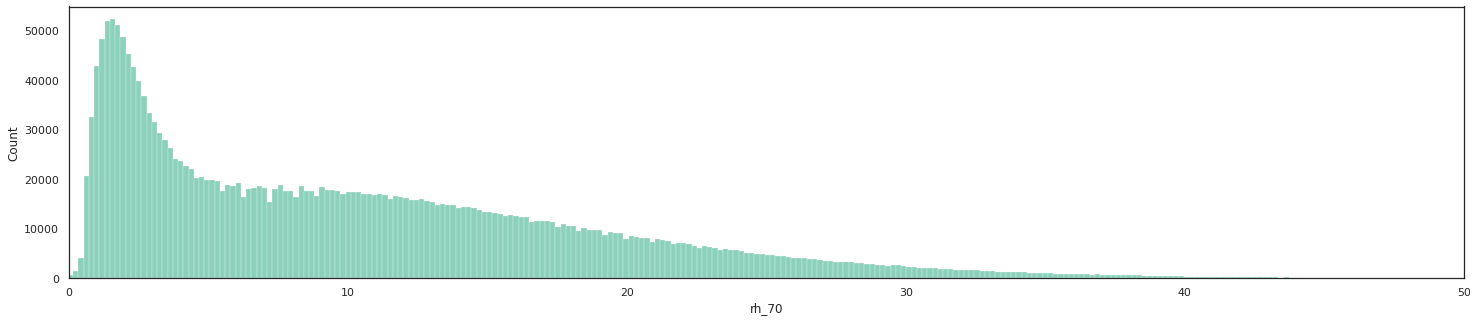

In [77]:
fig, ax = plt.subplots(1, 1, figsize=(25, 5))
sns.histplot(unburned[~unburned.index.isin(match.index)], x="rh_70")
ax.set_xlim((0, 50))

(0.0, 50.0)

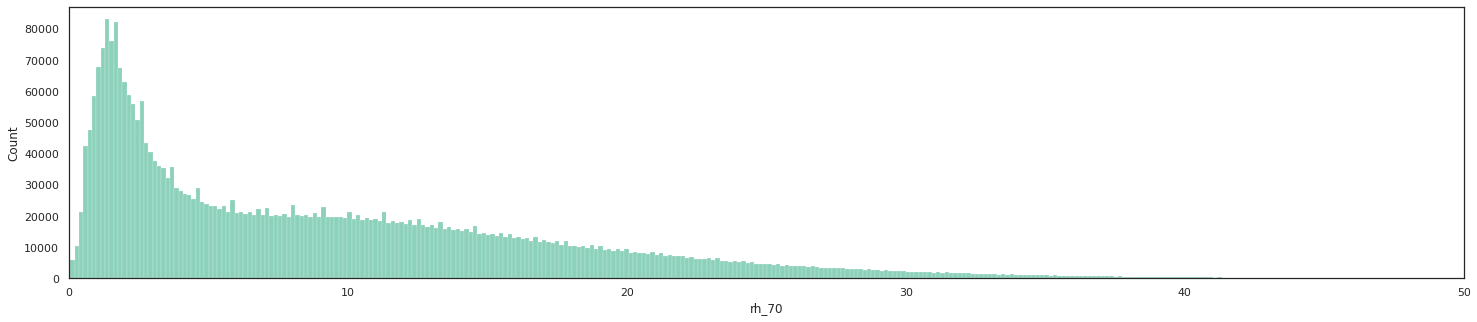

In [76]:
fig, ax = plt.subplots(1, 1, figsize=(25, 5))
sns.histplot(unburned, x="rh_70")
ax.set_xlim((0, 50))

(0.0, 300.0)

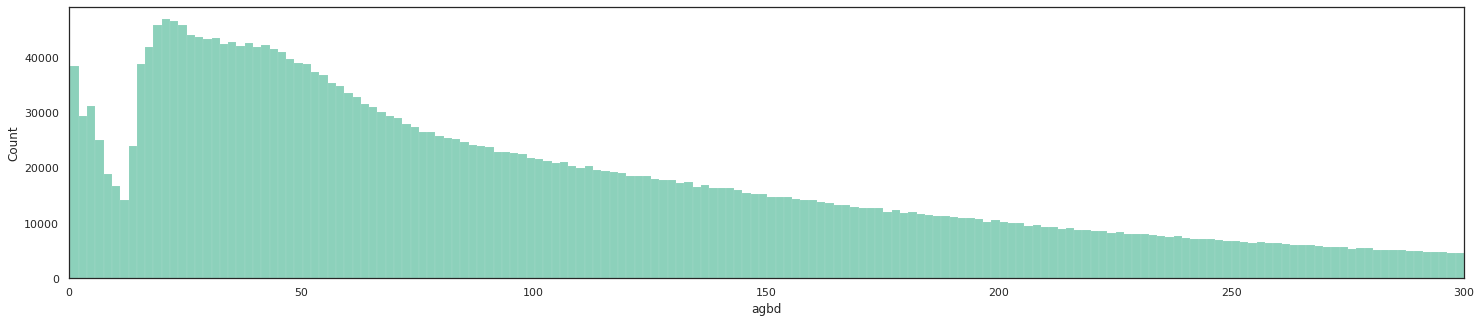

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(25, 5))
sns.histplot(unburned, x="agbd")
ax.set_xlim((0, 300))

In [87]:
unburned[unburned.index.duplicated()]

,longitude,latitude,absolute_time,geometry,fire_id,fire_size_acres,fire_name,fire_ig_date,dNBR_offst,dNBR_stdDv,...,elevation,slope,soil,ndvi,da_mean,da_std,da_median,da_min,da_max,da_year
shot_number,,,,,,,,,,,,,,,,,,,,,
19690000200125017,-119.359920,36.662426,2019-04-18 16:22:38.556506+00:00,POINT (-119.35992 36.66243),NaN,NaN,NaN,NaT,NaN,NaN,...,130.0,1.041743,5.0,0.719466,32769.0,32764.00000,32769.0,5.0,65533.0,2013.0
19690000200125017,-119.359920,36.662426,2019-04-18 16:22:38.556506+00:00,POINT (-119.35992 36.66243),NaN,NaN,NaN,NaT,NaN,NaN,...,130.0,1.041743,5.0,0.719466,49151.0,28374.45633,65533.0,5.0,65533.0,2016.0
19690000200125017,-119.359920,36.662426,2019-04-18 16:22:38.556506+00:00,POINT (-119.35992 36.66243),NaN,NaN,NaN,NaT,NaN,NaN,...,130.0,1.041743,5.0,0.719466,32769.0,32764.00000,32769.0,5.0,65533.0,2020.0
19690000200125045,-119.346504,36.671965,2019-04-18 16:22:38.787915+00:00,POINT (-119.34650 36.67197),NaN,NaN,NaN,NaT,NaN,NaN,...,138.0,1.319130,5.0,0.588100,32769.0,32764.00000,32769.0,5.0,65533.0,2018.0
19690000200125355,-119.196807,36.778074,2019-04-18 16:22:41.366432+00:00,POINT (-119.19681 36.77807),NaN,NaN,NaN,NaT,NaN,NaN,...,939.0,23.201521,5.0,0.586348,5.0,0.00000,5.0,5.0,5.0,2015.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240580800200084596,-119.105980,36.136051,2023-03-13 04:30:56.252357+00:00,POINT (-119.10598 36.13605),NaN,NaN,NaN,NaT,NaN,NaN,...,117.0,1.148282,5.0,0.626542,49151.0,28374.45633,65533.0,5.0,65533.0,2019.0
240580800200084597,-119.105509,36.136395,2023-03-13 04:30:56.260621+00:00,POINT (-119.10551 36.13639),NaN,NaN,NaN,NaT,NaN,NaN,...,116.0,2.164925,5.0,0.569444,32769.0,32764.00000,32769.0,5.0,65533.0,2004.0
240580800200084597,-119.105509,36.136395,2023-03-13 04:30:56.260621+00:00,POINT (-119.10551 36.13639),NaN,NaN,NaN,NaT,NaN,NaN,...,116.0,2.164925,5.0,0.569444,16387.0,28374.45633,5.0,5.0,65533.0,2007.0


In [99]:
unburned_lala = unburned[["ndvi", "agbd"]].drop_duplicates()
match_lala = match[["ndvi", "agbd"]].drop_duplicates()
undisturbed = unburned_lala[~unburned_lala.index.isin(match_lala.index)]

In [92]:
len(unburned_lala)

2916554

<AxesSubplot: xlabel='ndvi', ylabel='Count'>

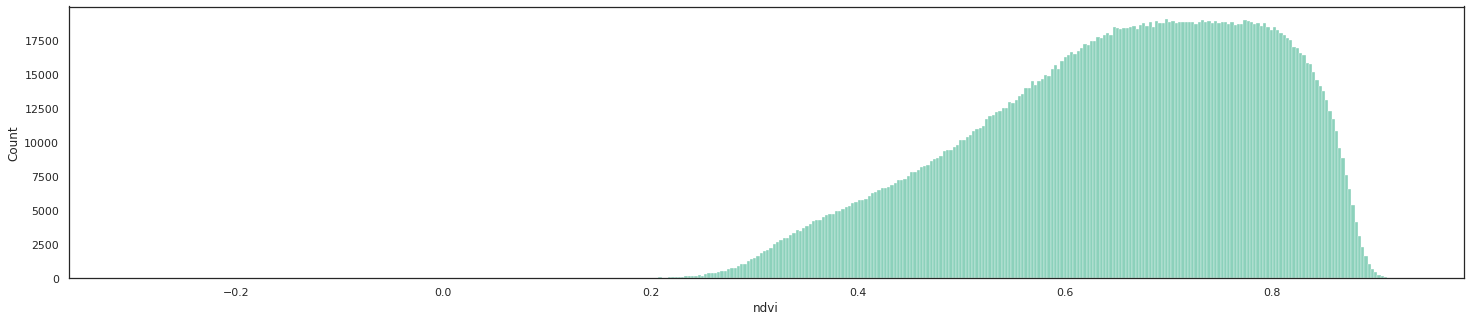

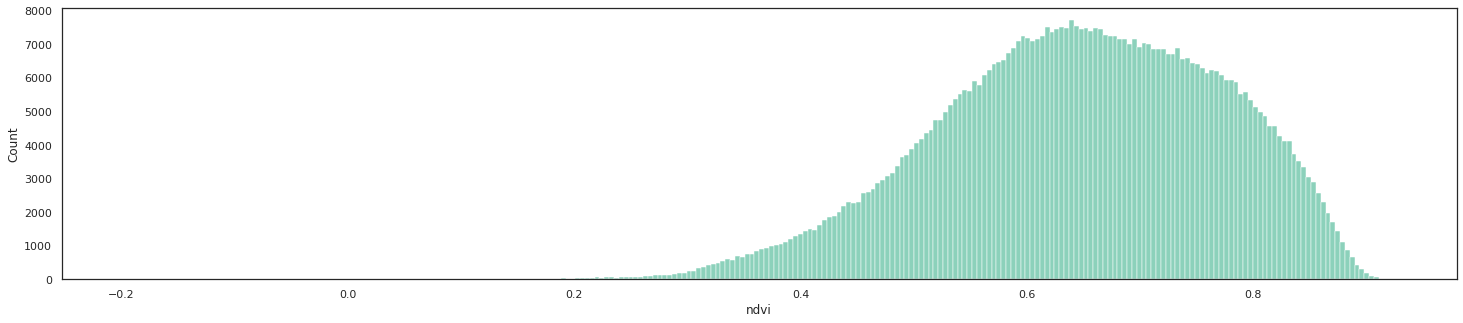

In [98]:
fig, ax = plt.subplots(1, 1, figsize=(25, 5))
sns.histplot(undisturbed, x="ndvi", ax=ax)

fig, ax = plt.subplots(1, 1, figsize=(25, 5))
sns.histplot(match_lala, x="ndvi", ax=ax)


(0.0, 400.0)

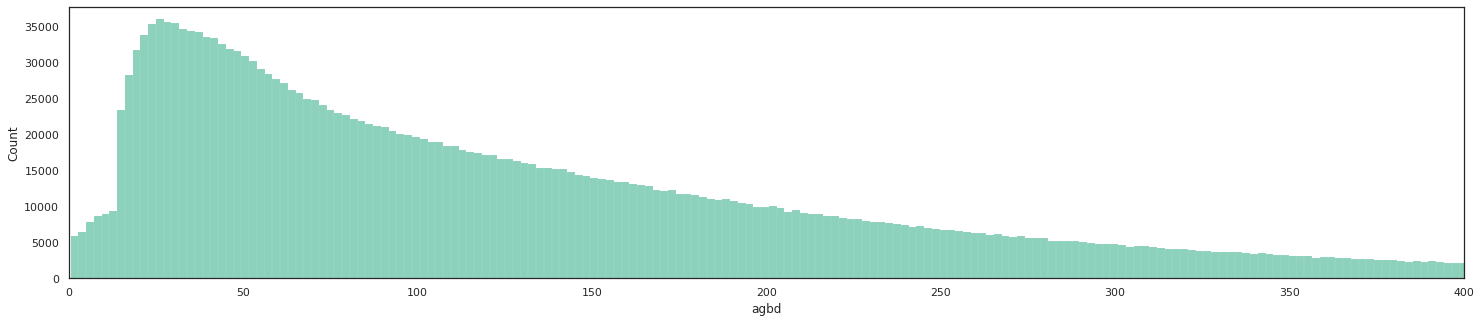

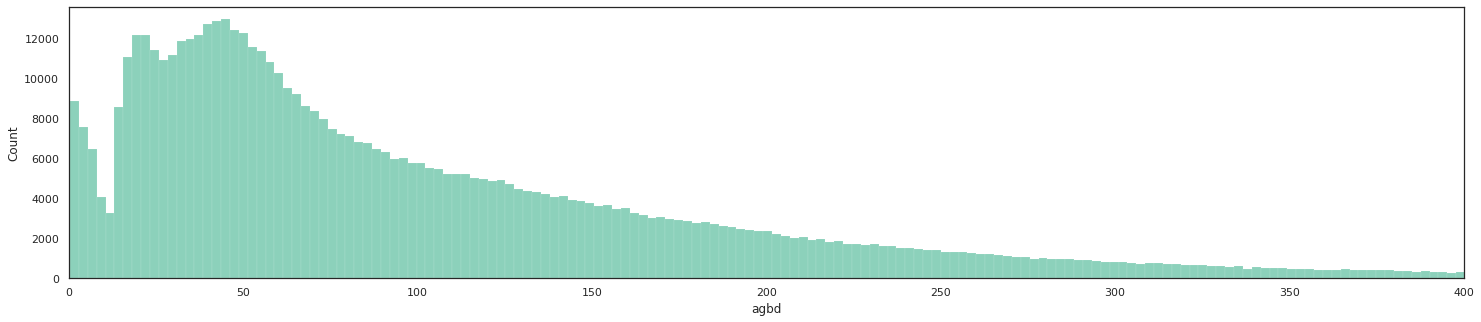

In [101]:
fig, ax = plt.subplots(1, 1, figsize=(25, 5))
sns.histplot(undisturbed, x="agbd", ax=ax)
ax.set_xlim((0, 400))

fig, ax = plt.subplots(1, 1, figsize=(25, 5))
sns.histplot(match_lala, x="agbd", ax=ax)
ax.set_xlim((0, 400))


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(25, 5))
sns.histplot(unburned_lala, x="ndvi", ax=ax)

fig, ax = plt.subplots(1, 1, figsize=(25, 5))
sns.histplot(match_lala, x="ndvi", ax=ax)

(0.0, 300.0)

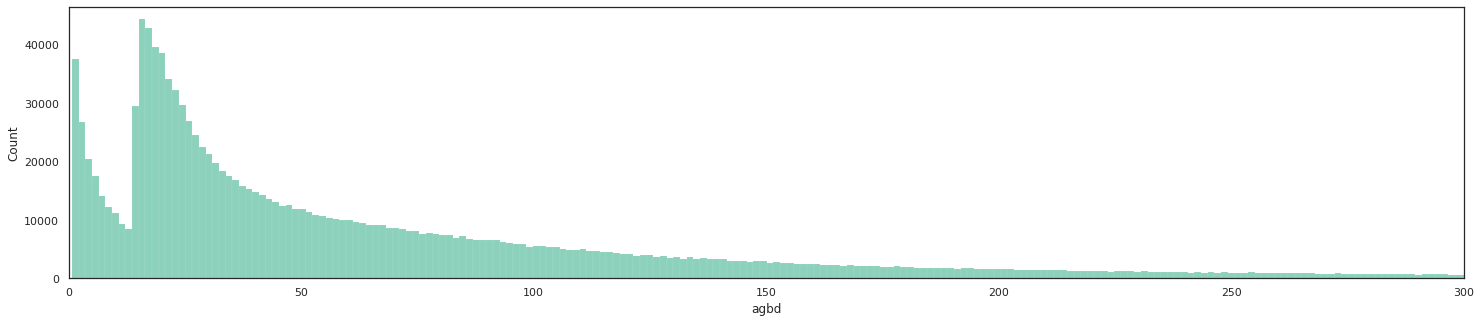

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(25, 5))
sns.histplot(burned, x="agbd")
ax.set_xlim((0, 300))

(0.0, 300.0)

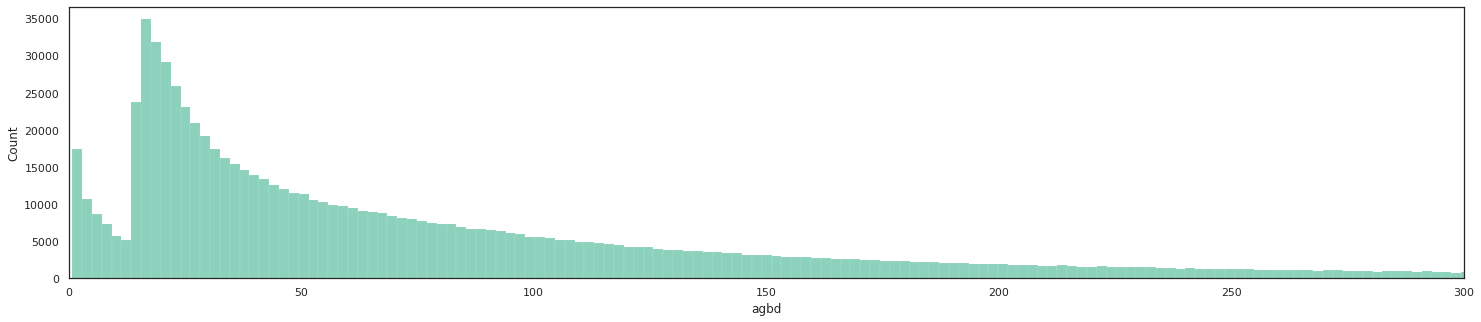

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(25, 5))
sns.histplot(burned[~burned.index.isin(match_b.index)], x="agbd")
ax.set_xlim((0, 300))

<AxesSubplot: xlabel='pre_fire_ndvi', ylabel='Count'>

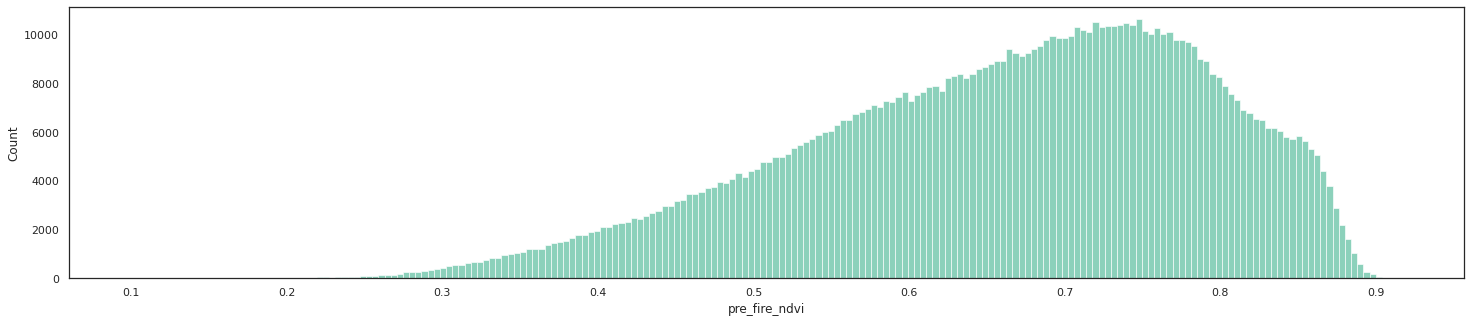

In [66]:
fig, ax = plt.subplots(1, 1, figsize=(25, 5))
sns.histplot(burned[~burned.index.isin(match_b.index)], x="pre_fire_ndvi")

<AxesSubplot: xlabel='pre_fire_ndvi', ylabel='Count'>

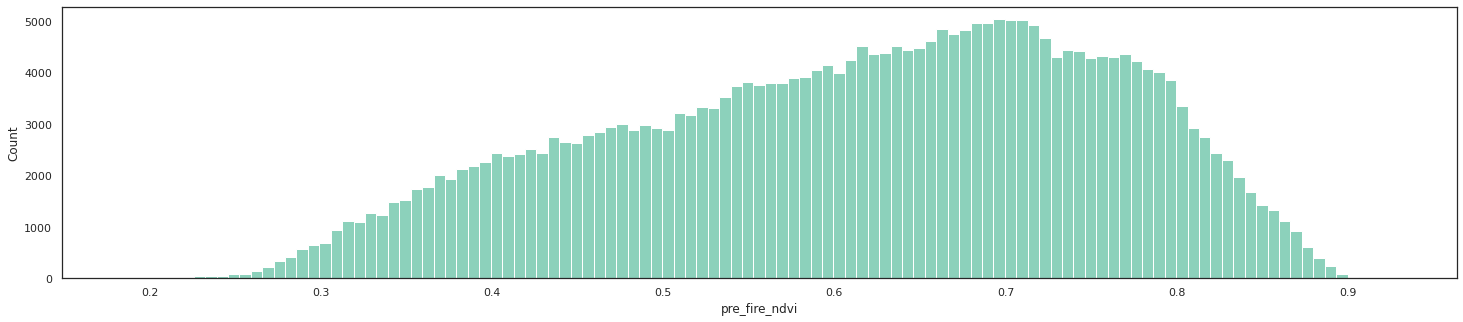

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(25, 5))
sns.histplot(match_b, x="pre_fire_ndvi")

<AxesSubplot: xlabel='da_year', ylabel='Count'>

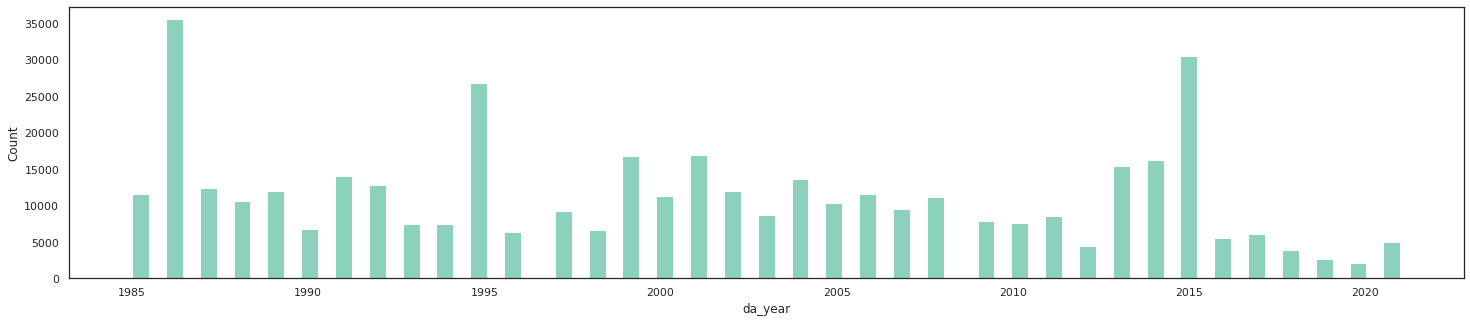

In [31]:
# Let's look at fire disturbances
fig, ax = plt.subplots(1, 1, figsize=(25, 5))
sns.histplot(brown_da, x="da_year")

<AxesSubplot: >

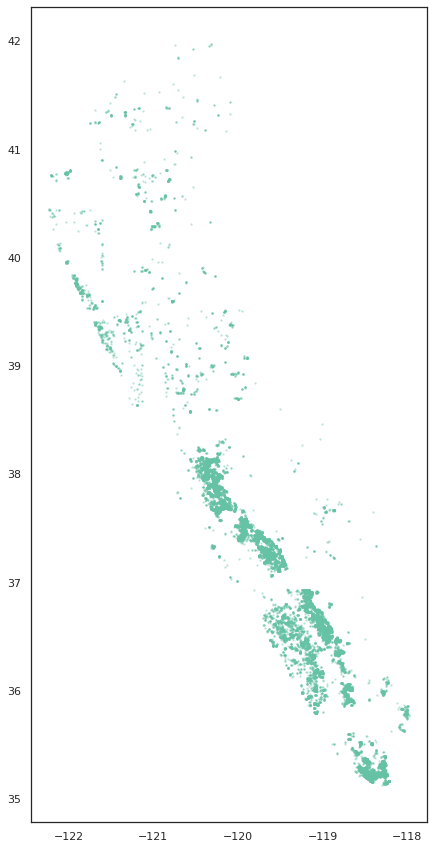

In [35]:
da_df = brown_da
da_df[da_df.da_year == 2015].plot(alpha=0.3, figsize=(15, 15), markersize=2)

In [33]:
print(drought_da.agbd.mean())
print(drought_da.agbd.std())

124.8948019938795
111.16823537476431


In [36]:
burned = burned.join(g, how="left")

In [37]:
match_b = burned[(burned.da_year - 1  > burned.fire_ig_date.dt.year) & (burned.da_year < burned.absolute_time.dt.year)]

In [38]:
len(burned), len(match_b)

(1371394, 279495)

<AxesSubplot: xlabel='da_min', ylabel='Count'>

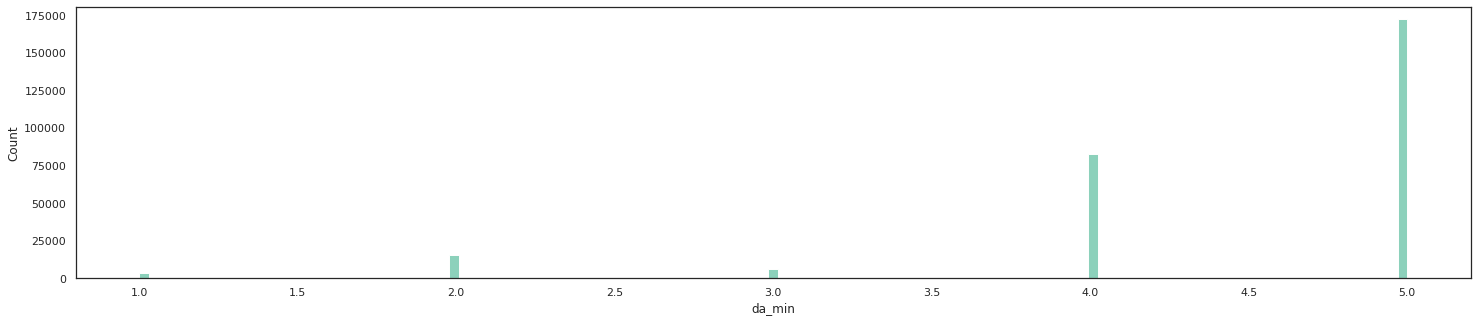

In [39]:
# Let's look at fire disturbances
fig, ax = plt.subplots(1, 1, figsize=(25, 5))
sns.histplot(match_b, x="da_min")

In [40]:
fire_da_b = match_b[match_b.da_min == 1]
timber_da_b = match_b[match_b.da_min == 2]
drought_da_b = match_b[match_b.da_min == 3]
brown_da_b = match_b[match_b.da_min == 5]
len(fire_da_b), len(timber_da_b), len(drought_da_b), len(brown_da_b)

(3632, 15429, 5874, 171970)

In [41]:
brown_da_b["years_to_da"] = brown_da_b.da_year - brown_da_b.fire_ig_date.dt.year

<AxesSubplot: xlabel='YSF', ylabel='Count'>

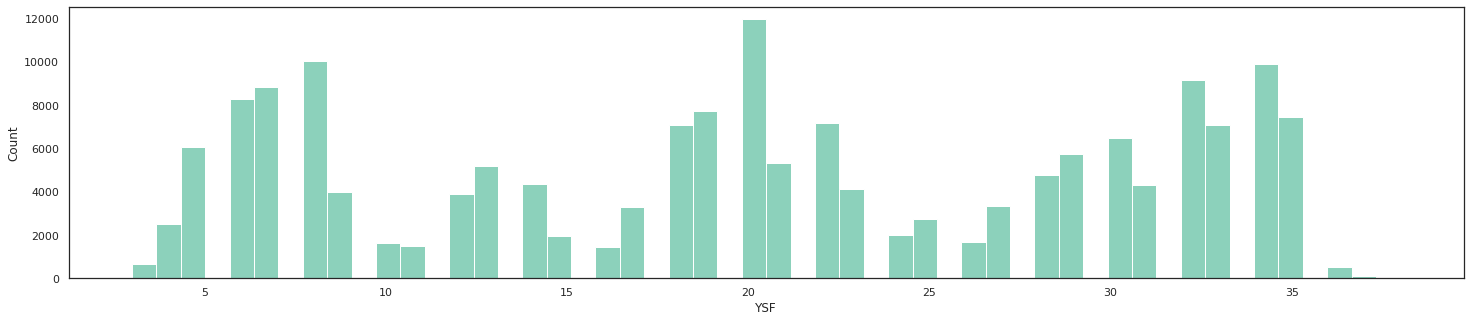

In [42]:
# Let's look at fire disturbances
fig, ax = plt.subplots(1, 1, figsize=(25, 5))
sns.histplot(brown_da_b, x="YSF")

<AxesSubplot: xlabel='da_year', ylabel='Count'>

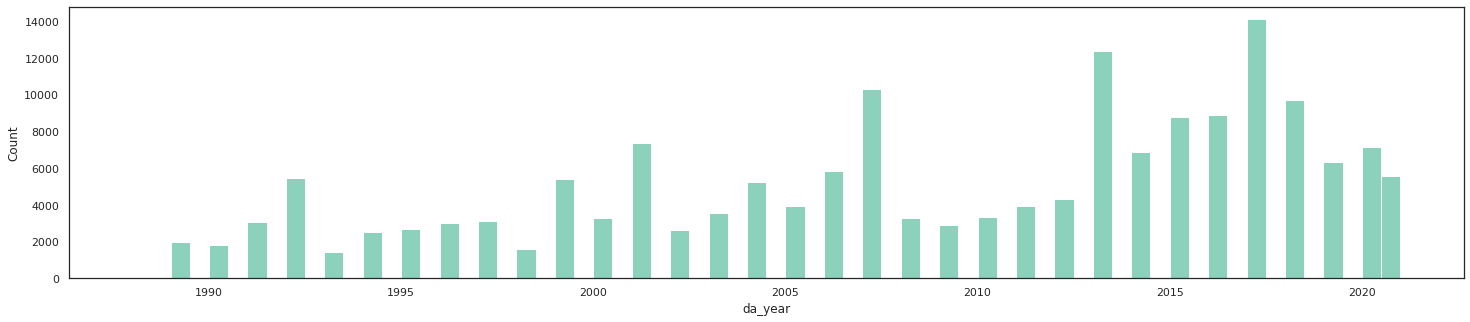

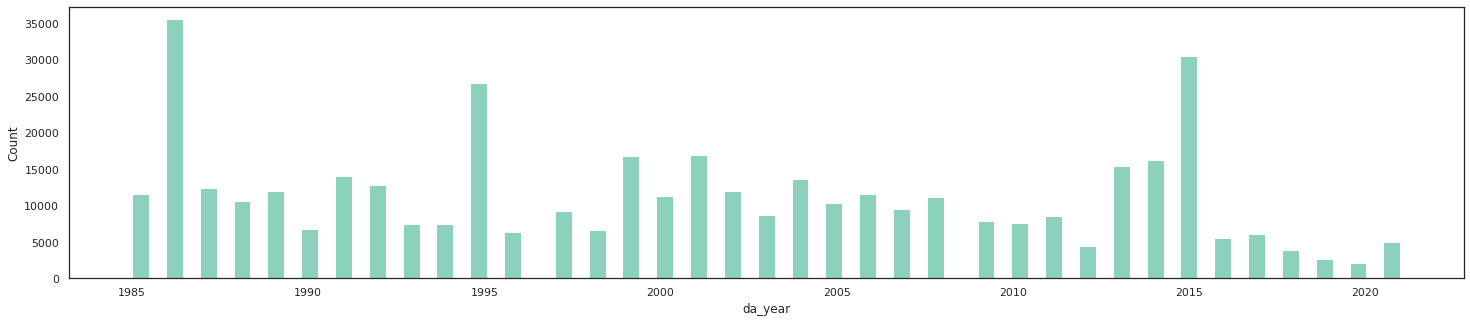

In [44]:
# Let's look at fire disturbances
fig, ax = plt.subplots(1, 1, figsize=(25, 5))
sns.histplot(brown_da_b, x="da_year")

# Let's look at fire disturbances
fig, ax = plt.subplots(1, 1, figsize=(25, 5))
sns.histplot(brown_da, x="da_year")

<AxesSubplot: >

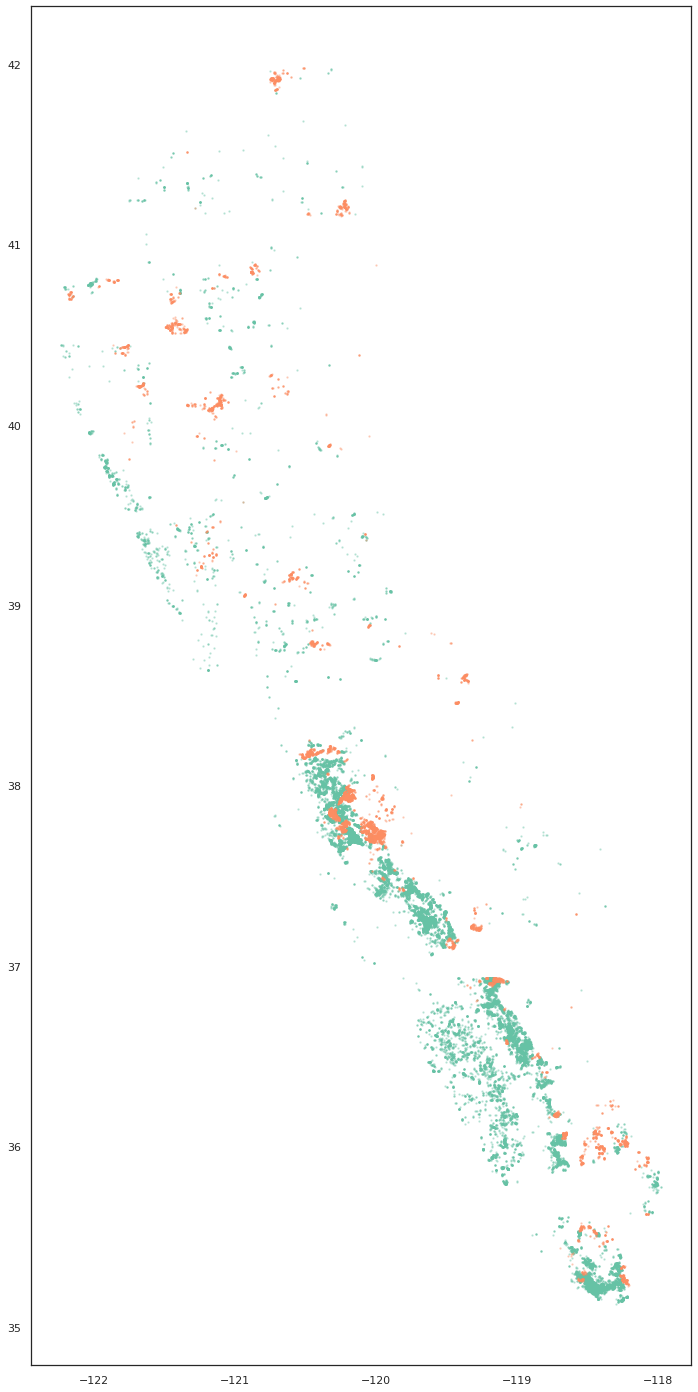

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(25, 25))

da_df = brown_da
da_df[da_df.da_year == 2015].plot(alpha=0.3, markersize=2, ax=ax)


da_df = brown_da_b
da_df[da_df.da_year == 2015].plot(alpha=0.3, markersize=2, ax=ax)

<AxesSubplot: >

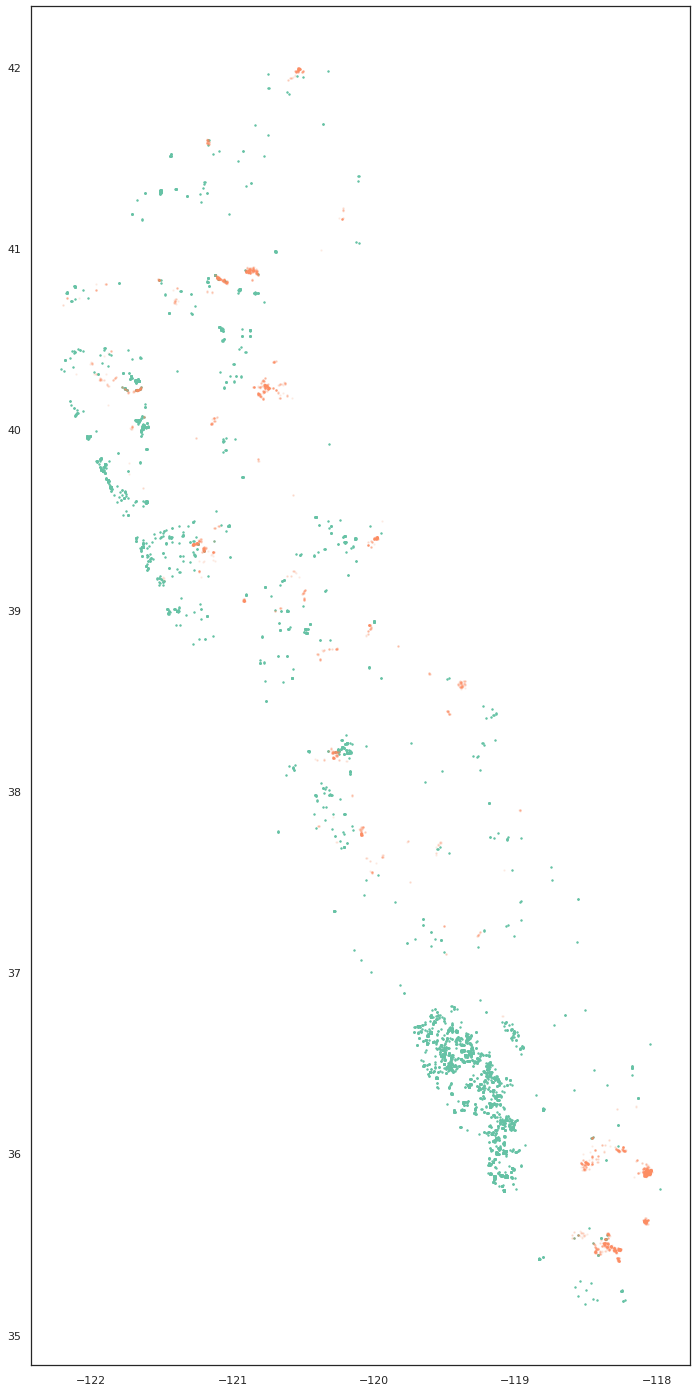

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(25, 25))

da_df = brown_da
da_df[da_df.da_year == 2012].plot(alpha=1, markersize=2, ax=ax)


da_df = brown_da_b
da_df[da_df.da_year == 2012].plot(alpha=0.1, markersize=2, ax=ax)

<AxesSubplot: >

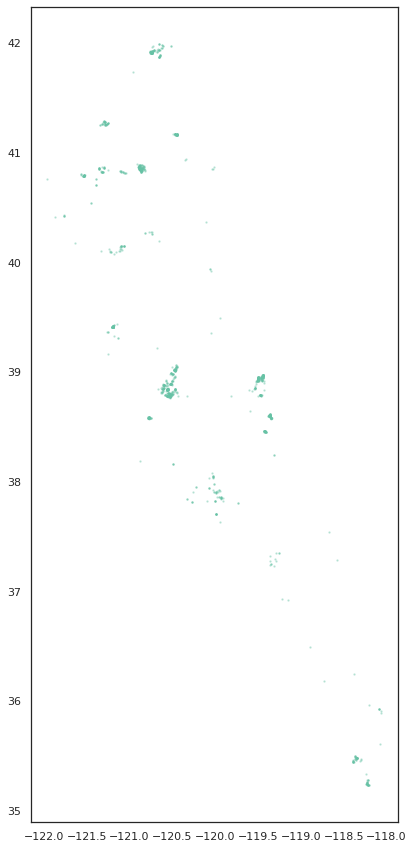

In [88]:
da_df = brown_da[brown_da.da_std == 0]
da_df[da_df.da_year == 2016].plot(alpha=0.3, figsize=(15, 15), markersize=2)

<AxesSubplot: xlabel='da_std', ylabel='Count'>

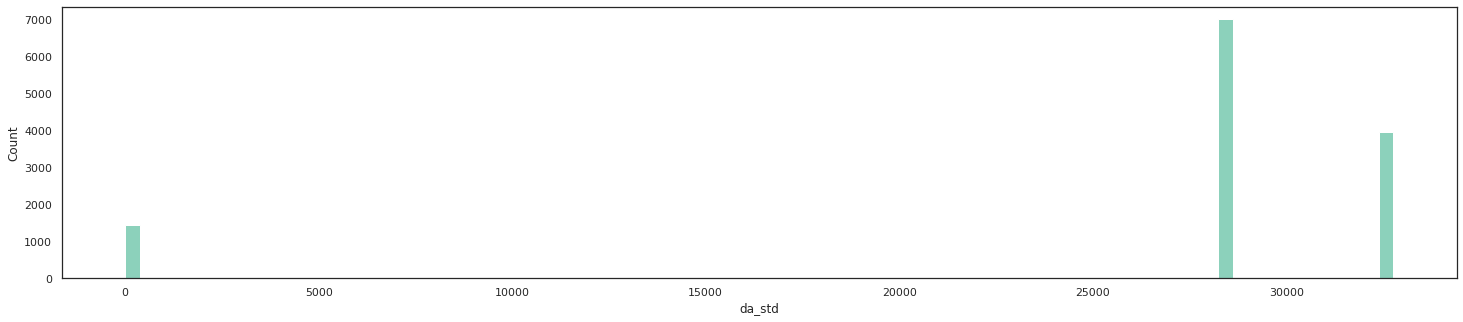

In [84]:
# Let's look at fire disturbances
fig, ax = plt.subplots(1, 1, figsize=(25, 5))
sns.histplot(da_df[da_df.da_year == 2013], x="da_std")

<AxesSubplot: xlabel='years_to_da', ylabel='Count'>

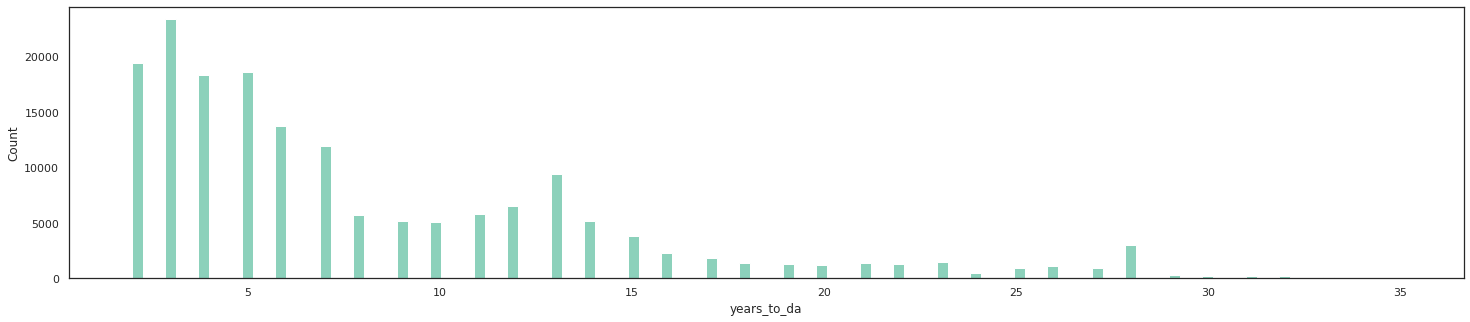

In [64]:
# Let's look at fire disturbances
fig, ax = plt.subplots(1, 1, figsize=(25, 5))
sns.histplot(brown_da, x="years_to_da")

In [65]:
brown_da[brown_da.da_std == 0]

,longitude,latitude,absolute_time,geometry,fire_id,fire_size_acres,fire_name,fire_ig_date,dNBR_offst,dNBR_stdDv,...,slope,soil,ndvi,da_mean,da_std,da_median,da_min,da_max,da_year,years_to_da
shot_number,,,,,,,,,,,,,,,,,,,,,
19690000200125511,-119.121835,36.831094,2019-04-18 16:22:42.655672+00:00,POINT (-119.12184 36.83109),CA3687411890520150801,146369.0,ROUGH,2015-07-31,-4.0,36.0,...,17.403015,5.0,0.585645,5.0,0.0,5.0,5.0,5.0,2017.0,2.0
19690000200125779,-118.992258,36.922354,2019-04-18 16:22:44.878838+00:00,POINT (-118.99226 36.92235),CA3687411890520150801,146369.0,ROUGH,2015-07-31,-4.0,36.0,...,27.642731,5.0,0.595002,5.0,0.0,5.0,5.0,5.0,2017.0,2.0
19690100200117347,-119.128245,36.819129,2019-04-18 16:22:42.420148+00:00,POINT (-119.12825 36.81913),CA3687411890520150801,146369.0,ROUGH,2015-07-31,-4.0,36.0,...,27.698189,5.0,0.608094,5.0,0.0,5.0,5.0,5.0,2017.0,2.0
19690200200126270,-119.126695,36.813609,2019-04-18 16:22:42.110248+00:00,POINT (-119.12669 36.81361),CA3687411890520150801,146369.0,ROUGH,2015-07-31,-4.0,36.0,...,22.246609,5.0,0.739869,5.0,0.0,5.0,5.0,5.0,2017.0,2.0
19690200200126308,-119.107847,36.826984,2019-04-18 16:22:42.432544+00:00,POINT (-119.10785 36.82698),CA3687411890520150801,146369.0,ROUGH,2015-07-31,-4.0,36.0,...,20.379974,5.0,0.536461,5.0,0.0,5.0,5.0,5.0,2017.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236921100200079705,-119.485817,37.116925,2023-02-17 13:59:10.296489+00:00,POINT (-119.48582 37.11693),CA3711311946719890728,11532.0,POWERHOUSE,1989-07-28,23.0,-9999.0,...,16.824085,5.0,0.609757,5.0,0.0,5.0,5.0,5.0,1997.0,8.0
236921100200079709,-119.483874,37.118282,2023-02-17 13:59:10.329553+00:00,POINT (-119.48387 37.11828),CA3711311946719890728,11532.0,POWERHOUSE,1989-07-28,23.0,-9999.0,...,10.728992,5.0,0.406288,5.0,0.0,5.0,5.0,5.0,1993.0,4.0
237531100200082492,-118.624620,37.320643,2023-02-21 12:23:13.132666+00:00,POINT (-118.62462 37.32064),CA3732211861819980829,3366.0,TOM,1998-08-29,6.0,-9999.0,...,17.562469,19.0,0.280288,5.0,0.0,5.0,5.0,5.0,2005.0,7.0
